In [51]:
### Print not only the last line in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [111]:
import sys
top_path = '..'
if top_path not in sys.path:
    sys.path.append(top_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from coffea import util
from pltStyle import pltStyle
import mplhep as hep
pltStyle('hep')
# %matplotlib notebook 
# %matplotlib notebook 

In [112]:
from helpers import hist_add, hist_mult, hist_div, dictionary_pattern, sum_subhist, xsecstr2float
from helpers import sum_neg_pos_eta, read_data

In [113]:
# add_tag = '_QCD-JME-leading3jets' #-etaAut18'
# add_tag = '_QCD-JME' #-etaAut18'
# add_tag = '_QCD-MG-Py8'
# add_tag = '_QCD-MG-Her'
add_tag = '_DY-MG-Her'
# add_tag = '_Herwig-TTBAR'
add_tag = '_Pythia-TTBAR'

def get_output(add_tag):
    tag_full = '_L5'+add_tag
    outname = '../out/CoffeaJERCOutputs'+tag_full+'.coffea'
    output = util.load(outname)
    return output

In [114]:
def get_file_dict(add_tag):
    if "_QCD-MG" in add_tag:
        if add_tag=='_DY-MG-Her':
            dataset_list_file = '../fileNames/QCD_Herwig_20UL18/xsecs_QCD_Herwig_corrected.txt'
        else:
            dataset_list_file = '../fileNames/QCD_MG_Py8_20UL18/xsecs_QCD_MG_py8.txt'
        with open(dataset_list_file) as f:
            lines = f.readlines()
        lines_split = [line.split() for line in lines]
        file_dict = {lineii[1]: xsecstr2float(lineii[2]) for lineii in lines_split }
    else:
        file_dict = 1
    return file_dict

In [115]:
# output_orig = output
def sum_output(output, add_tag, file_dict):
    if "_QCD-MG" in add_tag:
        response_sums = {key:sum(dictionary_pattern(output[key], "ptresponse_").values()).sum().value for key in output.keys()}
        scale_factors = hist_div(file_dict, response_sums)
        all_histo_keys = output[next(iter(output.keys()))].keys()
        result = {histo_key:sum_subhist(output, histo_key, scale_factors) for histo_key in all_histo_keys }
        output = result
    elif len(output.keys())==1:
        output = output[list(output.keys())[0]]
    return output

In [116]:
output = get_output(add_tag)
file_dict = get_file_dict(add_tag)
output = sum_output(output, add_tag, file_dict)
    
for key in output.keys():
    if 'response' in key:
        response_key = key
        break
        
fine_etabins=False
one_bin=False
if fine_etabins==True:
    ptbins = np.array([15, 40, 150, 400, 4000, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = output[response_key].axes["jeteta"].edges #output['ptresponse'].axis('jeteta').edges()
elif one_bin==True:
    ptbins = np.array([15, 10000])
    ptbins_c = (ptbins[:-1]+ptbins[1:])/2
    etabins = np.array([-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5])
    etabins = np.array([etabins[0], 0, etabins[-1]])
#     etabins = np.array([etabins[3], 0, etabins[-4]])
else:
    ptbins = output[response_key].axes["pt_gen"].edges 
#     ptbins = ptbins[2:] #because there is a pt cut on pt gen and no point of fitting and plotting below that
    ptbins_c = output[response_key].axes['pt_gen'].centers
#     etabins = np.array([-5.191, -3.489, -3.139, -2.853,   -2.5, -2.322,  -1.93, -1.653, -1.305, -0.783,      0,  0.783,  1.305,  1.653,   1.93,  2.322,    2.5,  2.853,  3.139,  3.489, 5.191])
    etabins = np.array([-5.191, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5.191])

### Sum together all the different flavors

In [117]:
def combine_flavors(output, sumeta=True):
    all_samples = [key[11:] for key in output.keys() if 'ptresponse' in key]
    hists = {}
    # (output['ptresponse_u']+output['ptresponse_ubar']+output['ptresponse_d']+output['ptresponse_dbar'])[:,sum,sum]
    hists['q'] = (output['ptresponse_u']+output['ptresponse_ubar']+output['ptresponse_d']+output['ptresponse_dbar']+output['ptresponse_s']+output['ptresponse_sbar'])[:,sum,:]
    hists['g'] = (output['ptresponse_g'])[:,sum,:]
    hists['b'] = (output['ptresponse_b']+output['ptresponse_bbar'])[:,sum,:]
    hists['c'] = (output['ptresponse_c']+output['ptresponse_cbar'])[:,sum,:]
    
    try:
        hists['unmatched'] = output.get('ptresponse_unmatched')[:,sum,:]
    except(TypeError):
        print('Took untagged')
        hists['unmatched'] = output.get('ptresponse_untagged')[:,sum,:]
        
#     if len(untagged)>0: 
#         hists['untagged'] = (untagged)[:,sum,sum]
#     else:
#         hists['untagged'] = 0

    all_responses = {samp:output['ptresponse_'+samp] for samp in all_samples}
    hists['all'] = sum(all_responses.values())[:,sum,:]
    
    if sumeta:
        for key in hists.keys():
            hists[key] = hists[key][:,sum]
    return hists

In [118]:
# add_tag = '_QCD-JME-leading3jets' #-etaAut18'
# add_tag = '_QCD-JME' #-etaAut18'
# add_tag = '_QCD-MG-Py8'
# add_tag = '_QCD-MG-Her'
# add_tag = '_DY-MG-Her'
# add_tag = '_Herwig-TTBAR'
# add_tag = '_Pythia-TTBAR'

In [119]:
# output

In [172]:
hists_dict = {}
# samples = ['_DY-MG-Py', '_DY-JME']
# samples = ['_QCD-Py', '_QCD-MG-Py']
# samples = ['_DY-MG-Py', '_DY-FxFx_test']
# samples = ["_QCD-MG-Her", "_QCD-MG-Py"]
samples = ["_Herwig-TTBAR_test", "_Pythia-TTBAR"]

for sample in samples:
    output = get_output(sample)
    file_dict = get_file_dict(sample)
    output = sum_output(output, sample, file_dict)
    hists = combine_flavors(output)
    hists_dict[sample] = hists

In [173]:
# output['cutflow']['all_events']

In [174]:
# output['cutflow']['all_events']

In [175]:
# hists_dict

/tmp/anpotreb/ipykernel_13660/950866048.py:12: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (hists1[flav].values()/qfracs['all'])[plot_range]


<IPython.core.display.Javascript object>


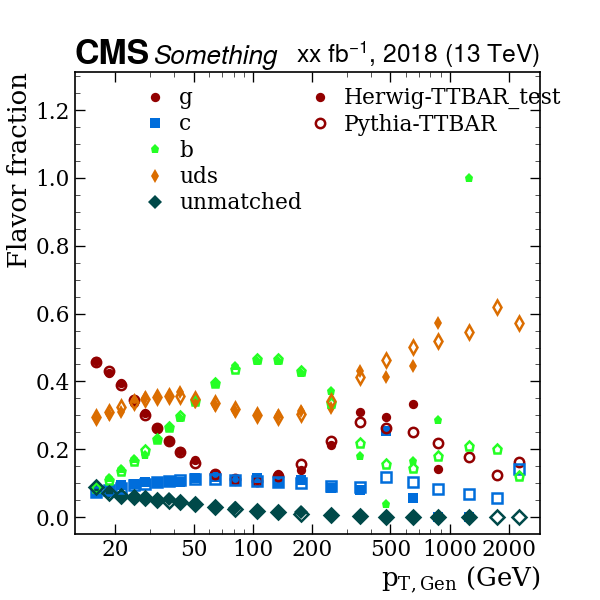

/tmp/anpotreb/ipykernel_13660/950866048.py:28: RuntimeWarning: invalid value encountered in true_divide
  qfracs2[flav] = (hists2[flav].values()/qfracs2['all'])[plot_range]


Saving plot with the name =  ../fig/fractions/fraction_Herwig-TTBAR_test_Pythia-TTBAR


In [176]:
# samples = ["_DY-MG-Her", "_DY-MG-Py"]
hists1 = hists_dict[samples[0]]
hists2 = hists_dict[samples[1]]

plot_range = range(0, len(ptbins_c)-9) if 'DY' in "".join(samples) else range(0, len(ptbins_c)-6)
ptbins_c_plot = ptbins_c[plot_range]

qfracs = {'all': hists1['all'].values()}
for flav in hists1.keys():
    if 'all' in flav:
        continue
    qfracs[flav] = (hists1[flav].values()/qfracs['all'])[plot_range]

points_ls = [] 
fig, ax = plt.subplots()
for flav, lab in zip(['g', 'c', 'b', 'q', 'unmatched'], ['g', 'c', 'b', 'uds', 'unmatched']):
    if 'all' in flav:
        continue
    points = ax.plot(ptbins_c_plot, qfracs[flav], linewidth=0, label=lab)
    if 'g' == flav:
        points_ls.append(points[0])
    
qfracs2 = {'all': hists2['all'].values()}
for flav in hists2.keys():
    if 'all' in flav:
        continue
    try:
        qfracs2[flav] = (hists2[flav].values()/qfracs2['all'])[plot_range]
    except(AttributeError):
        qfracs2[flav] = [0]*len(plot_range)

ax.set_prop_cycle(None)
for flav, lab in zip(['g', 'c', 'b', 'q', 'unmatched'], ['g', 'c', 'b', 'uds', 'unmatched']):
    if 'all' in flav:
        continue
    points = ax.plot(ptbins_c_plot, qfracs2[flav], linewidth=0, mfc='none', markeredgewidth=1.2)
    if 'g' == flav:
        points_ls.append(points[0])
ax.set_xscale('log')
ax.set_xlabel('$p_{T,Gen}$ (GeV)')
ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

xlims = ax.get_xlim()

ax.set_xticks([])
ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
legend1 = ax.legend(points_ls, [samples[0][1:], samples[1][1:]], loc="upper left", bbox_to_anchor=(0.48, 1))
leg2 = ax.legend(ncol=1, loc='upper right', bbox_to_anchor=(0.52, 1))
ax.add_artist(legend1)
# ax.add_artist(leg2)

ylims = ax.get_ylim()
ax.set_xlim(xlims)
ax.set_ylim(ylims[0], ylims[1]*1.25)

# ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
hep.cms.label("Something", data=True, lumi="xx", year=2018, fontsize=15.6/1.25)

import os
if not os.path.exists("../fig/fractions"):
    os.mkdir("../fig/fractions")
    
fig_name = '../fig/fractions/fraction'+"".join(samples)
print("Saving plot with the name = ", fig_name)
plt.savefig(fig_name+'.pdf');
plt.savefig(fig_name+'.png');

# ptbins_c
1;

### Deriving the uncertainties

In [378]:
# ptbins_c
pt200bin = np.searchsorted(ptbins,200)
# ptbins_c[14]

In [70]:
# hists_dict = {}
qfrac_dict = {}
correction_dict = {}

In [73]:
samples = ['_QCD-MG-Py', '_QCD-MG-Her', '_DY-MG-Her', '_DY-MG-Py', '_Herwig-TTBAR', '_Pythia-TTBAR']

for sample in samples:
    output = get_output(sample)
    file_dict = get_file_dict(sample)
    output = sum_output(output, sample, file_dict)
    hists = combine_flavors(output, sumeta=False)
    
    qfracs = {'all': sum_neg_pos_eta(hists['all']).values()}
    for flav in hists.keys():
        if 'all' in flav:
            continue
        qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])
        
    flavors = ['g', 'c', 'b', 'q']
    qfracs2 = {key: qfracs[key] for key in qfracs.keys() if key in flavors}
    
    qfrac_dict[sample] = qfracs2
    correction_dict[sample] = {flav: read_data("Median", flav, "_L5"+sample+"_fineeta",'../') for flav in flavors}


/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])
/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])
/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])


Took unmatched


/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])
/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])
/tmp/anpotreb/ipykernel_13660/2370966092.py:13: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])


In [98]:
def getRmix(samp1, samp2, use_each_mix=False):
    '''Rf defined in Eq.(26) in https://arxiv.org/pdf/1607.03663.pdf'''
    if use_each_mix==False:        
        Rf = hist_mult(
            hist_add(
                correction_dict[samp1],
                hist_mult(correction_dict[samp2],-1)
            ),
        qfrac_dict[samp1])
    else:
        Rf = hist_add(
            hist_mult(
                correction_dict[samp1],
                qfrac_dict[samp1]
            ),
            hist_mult(
                hist_mult(
                    correction_dict[samp2],
                    qfrac_dict[samp2]
                ),
                -1
            )
        )
    Rmix = sum(Rf.values())
    return Rmix

In [76]:
Rttbar = getRmix('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=True)

In [421]:
# hist_add(getR('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=True),
#     hist_mult(getR('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=False), -1))

In [104]:
Rttbar = getRmix('_Herwig-TTBAR', '_Pythia-TTBAR', use_each_mix=False)
RZjet = getRmix('_DY-MG-Her', '_DY-MG-Py', use_each_mix=False)
Rdijet = getRmix('_DY-MG-Her', '_DY-MG-Py', use_each_mix=False)


In [105]:
Rref = RZjet[np.searchsorted(ptbins_c, 200), 0] + (Rdijet - np.array([Rdijet[:,0]]).T )

In [106]:
RZjet[np.searchsorted(ptbins_c, 200), 0]

-0.052023656453424494

In [107]:
DRflav = Rttbar - Rref
DRflav

array([[0.05204386, 0.05339711, 0.05401943, ..., 0.05291606, 0.08676747,
        0.06674879],
       [0.05196416, 0.05312682, 0.0523442 , ..., 0.0534091 , 0.09666164,
        0.07535077],
       [0.05210944, 0.05184879, 0.05225901, ..., 0.05726413, 0.1141145 ,
        0.09345208],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [412]:
R_mix_dict = hist_mult(
    hist_add(
        correction_dict['_Herwig-TTBAR'],
        hist_mult(correction_dict['_Pythia-TTBAR'],-1)
    ),
    qfrac_dict['_Herwig-TTBAR'])

In [413]:
# R_mix_dict

{'g': array([[ 0.00197178,  0.00224616,  0.00223491, ...,  0.0043882 ,
         -0.00058536,  0.00166266],
        [ 0.00261992,  0.00283154,  0.00286385, ...,  0.0049895 ,
          0.00086897,  0.00185507],
        [ 0.00263753,  0.00281219,  0.00273248, ...,  0.00361315,
          0.00098622,  0.00123152],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]),
 'c': array([[-2.18133424e-04, -2.91913065e-04, -2.18621081e-04, ...,
          2.66068655e-04,  1.01836283e-04,  3.27730071e-04],
        [-3.33571398e-04, -3.05603978e-04, -2.93866530e-04, ...,
          1.35843138e-04, -9.28091162e-06,  2.64694382e-04],
        [-5.18987314e-04, -5.42041318e-04, -5.69035835e-04, ...,
         -9.73581362e-06,  3.39890925e-05,  1.

In [355]:
qfracs = {'all': sum_neg_pos_eta(hists['all']).values()}
for flav in hists.keys():
    if 'all' in flav:
        continue
    qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])

/tmp/anpotreb/ipykernel_2302/4094375483.py:5: RuntimeWarning: invalid value encountered in true_divide
  qfracs[flav] = (sum_neg_pos_eta(hists[flav]).values()/qfracs['all'])


In [401]:
# flavors = ['g', 'c', 'b', 'q']
# data_read0 = {flav: read_data("Median", flav, "_L5"+samples[0]+"_fineeta",'../') for flav in flavors}
# data_read1 = {flav: read_data("Median", flav, "_L5"+samples[1]+"_fineeta",'../') for flav in flavors}


In [402]:
# etabins = np.array([-5.191, -4.889, -4.716, -4.538, -4.363, -4.191, -4.013, -3.839, -3.664, -3.489,
#                         -3.314, -3.139, -2.964, -2.853,  -2.65,   -2.5, -2.322, -2.172, -2.043,  -1.93, 
#                         -1.83,  -1.74, -1.653, -1.566, -1.479, -1.392, -1.305, -1.218, -1.131, -1.044,
#                         -0.957, -0.879, -0.783, -0.696, -0.609, -0.522, -0.435, -0.348, -0.261, -0.174,
#                         -0.087,  0,  0.087,  0.174,  0.261,  0.348,  0.435,  0.522,  0.609,  0.696, 
#                         0.783,  0.879,  0.957,  1.044,  1.131,  1.218,  1.305,  1.392,  1.479,  1.566, 
#                         1.653,   1.74,   1.83,   1.93,  2.043,  2.172,  2.322,    2.5,   2.65,  2.853,
#                         2.964,  3.139,  3.314,  3.489,  3.664,  3.839,  4.013,  4.191,  4.363,  4.538,
#                         4.716,  4.889, 5.191])
# jeteta_axis = hist.axis.Variable(etabins, name="jeteta", label=r"Jet $\eta$")

# # jeteta_axis = hist.axis.(etabins, name="jeteta", label=r"Jet $\eta$")


In [358]:
# hist_Pl = rebin_hist(bla2, 'jeteta', edPl)
# hist_Mi = rebin_hist(bla2, 'jeteta', edMi)

# hist_MiPl = mirror_eta_to_plus(hist_Mi)
# hist_MiPl+hist_Pl

In [403]:
# qfracs2 = {key: qfracs[key] for key in qfracs.keys() if key in flavors}

In [404]:
# sum(qfracs2.values())

In [368]:
R_Zjet = sum(R_mix.values())

<IPython.core.display.Javascript object>


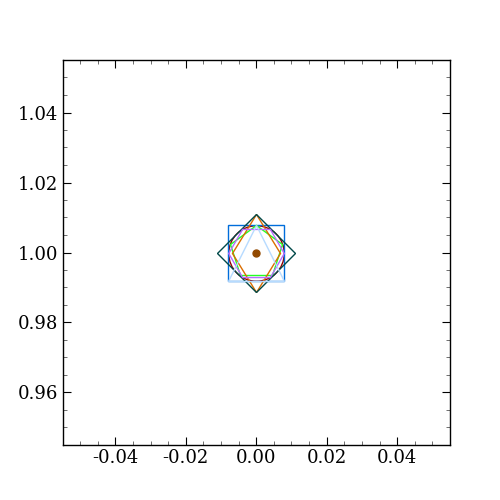

In [38]:
fig, ax = plt.subplots()
for i in range(7):
    ax.plot([1], markersize=40, mfc='none', mew=1)
ax.plot([1],  '.', markersize=10, mew=1)
# ax.set_xlim([-0.02,0.02])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from cycler import cycler

In [96]:
# plt.style.use('default')
pltStyle('presentation-square')
# hep.style.use("ATLAS")
my_parms = plt.rcParams.copy()
plt.style.use(hep.style.ROOT)
root_parms = plt.rcParams.copy()
# cols_cyc = cycler(color=colourblind_cols)

In [ ]:
parms_default = plt.rcParams.copy()

In [144]:
qfracs2 = {key: qfracs[key] for key in qfracs.keys() if key in flavors}

In [135]:
qfracs['q'].shape

(28, 82)

In [154]:
li = np.array([1,2,3,5,6])

In [156]:
li[[1,4]]

array([2, 6])

In [124]:
for key in root_parms.keys():
    if "legend" in key:
        print(key, root_parms[key])

legend.borderaxespad 0.5
legend.borderpad 0.5
legend.columnspacing 2.0
legend.edgecolor 0.8
legend.facecolor inherit
legend.fancybox True
legend.fontsize small
legend.framealpha 0.8
legend.frameon False
legend.handleheight 0.7
legend.handlelength 1.5
legend.handletextpad 0.8
legend.labelspacing 0.5
legend.loc best
legend.markerscale 1.0
legend.numpoints 1
legend.scatterpoints 1
legend.shadow False
legend.title_fontsize None


In [97]:
for key in my_parms.keys():
    if my_parms[key] == root_parms[key]:
        continue
    
    print(key, ", my_parms = ", my_parms[key], ", ROOT style = ", root_parms[key])

axes.labelsize , my_parms =  8.8 , ROOT style =  medium
axes.linewidth , my_parms =  0.8 , ROOT style =  2.0
axes.unicode_minus , my_parms =  True , ROOT style =  False
figure.figsize , my_parms =  [3.7, 3.5] , ROOT style =  [10.0, 10.0]
font.sans-serif , my_parms =  ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif'] , ROOT style =  ['TeX Gyre Heros', 'Helvetica', 'Arial']
font.size , my_parms =  10.0 , ROOT style =  26.0
grid.alpha , my_parms =  1.0 , ROOT style =  0.8
grid.linestyle , my_parms =  - , ROOT style =  :
legend.borderpad , my_parms =  0.4 , ROOT style =  0.5
legend.fontsize , my_parms =  8.0 , ROOT style =  small
legend.frameon , my_parms =  True , ROOT style =  False
legend.handlelength , my_parms =  2.0 , ROOT style =  1.5
mathtext.bf , my_parms =  sans:bold , ROOT style =  TeX Gyre Heros:bold
mathtext.cal , my_parms =  cursive , ROOT style =  TeX Gyre Her

In [ ]:
for key in plt.rcParams.keys():
    if "line" not in key:
        continue
    print(key, plt.rcParams[key])

In [ ]:
for key in plt.rcParams.keys():
    if "line" not in key:
        continue
    print(key, plt.rcParams[key])

In [158]:
import hist
hist.rebin(2)

rebin(2)

In [ ]:
plt.rcParams

In [ ]:
plt.plot([1,4,3,6,8,9], color='b', marker='.', linewidth=0, markersize=24, markerfacecolor='white', markeredgewidth=1)

In [300]:
# def rebin_hist(h, axis_name, edges):
#     '''Stolen from Kenneth Long
#     https://gist.github.com/kdlong/d697ee691c696724fc656186c25f8814
#     '''
#     if type(edges) == int:
#         return h[{axis_name : hist.rebin(edges)}]

#     ax = h.axes[axis_name]
#     ax_idx = [a.name for a in h.axes].index(axis_name)
#     if not all([np.isclose(x, ax.edges).any() for x in edges]):
#         raise ValueError(f"Cannot rebin histogram due to incompatible edges for axis '{ax.name}'\n"
#                             f"Edges of histogram are {ax.edges}, requested rebinning to {edges}")
        
#     # If you rebin to a subset of initial range, keep the overflow and underflow
#     overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
#     underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
#     flow = overflow or underflow
#     new_ax = hist.axis.Variable(edges, name=ax.name, overflow=overflow, underflow=underflow)
#     axes = list(h.axes)
#     axes[ax_idx] = new_ax
    
#     hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

#     # Offset from bin edge to avoid numeric issues
#     offset = 0.5*np.min(ax.edges[1:]-ax.edges[:-1])
#     edges_eval = edges+offset
#     edge_idx = ax.index(edges_eval)
#     # Avoid going outside the range, reduceat will add the last index anyway
#     if edge_idx[-1] == ax.size+ax.traits.overflow:
#         edge_idx = edge_idx[:-1]

#     if underflow:
#         # Only if the original axis had an underflow should you offset
#         if ax.traits.underflow:
#             edge_idx += 1
#         edge_idx = np.insert(edge_idx, 0, 0)

#     # Take is used because reduceat sums i:len(array) for the last entry, in the case
#     # where the final bin isn't the same between the initial and rebinned histogram, you
#     # want to drop this value. Add tolerance of 1/2 min bin width to avoid numeric issues
#     hnew.values(flow=flow)[...] = np.add.reduceat(h.values(flow=flow), edge_idx, 
#             axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
#     if hnew._storage_type() == hist.storage.Weight():
#         hnew.variances(flow=flow)[...] = np.add.reduceat(h.variances(flow=flow), edge_idx, 
#                 axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
#     return hnew

In [306]:
ed = bla2.axes.edges[1]
edPl = ed[ed>=0]
edMi = ed[ed<=0]
jeteta_axis_Pl = hist.axis.Variable(edPl, name="jeteta", label=r"Jet $\eta$")
jeteta_axis_Mi = hist.axis.Variable(edMi, name="jeteta", label=r"Jet $\eta$")

In [ ]:
allhistval = all_hist.values()
plot_range = range(0, len(ptbins_c)-9) if 'DY' in add_tag else range(0, len(ptbins_c)-6)
ptbins_c_plot = ptbins_c[plot_range]
q_frac = (hists['q'].values()/allhistval)[plot_range]
g_frac = (hists['g'].values()/allhistval)[plot_range]
b_frac = (hists['b'].values()/allhistval)[plot_range]
c_frac = (hists['c'].values()/allhistval)[plot_range]
# unt_frac = (untagged_hist.values()/allhistval)[plot_range]

fig, ax = plt.subplots()
ax.plot(ptbins_c_plot, q_frac, 'o', label="uds")
ax.plot(ptbins_c_plot, c_frac, 'o', label="c")
ax.plot(ptbins_c_plot, b_frac, 'o', label="b")
ax.plot(ptbins_c_plot, g_frac, 'o', label="g")
# ax.plot(ptbins_c_plot, unt_frac, 'o', label="untagged")
ax.set_xscale('log')
ax.set_xlabel('$p_{T,Gen}$ (GeV)')
ax.set_ylabel("Flavor fraction")
# fig.suptitle("Blaaah $x^2_5$")

xlims = ax.get_xlim()

ax.set_xticks([])
ax.set_xticks([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
leg1 = ax.legend(ncol=2)

ax.set_xlim(xlims)

import os
if not os.path.exists("../fig/fractions"):
    os.mkdir("../fig/fractions")
    
fig_name = '../fig/fractions/fraction'+tag_full
print("Saving plot with the name = ", fig_name)
plt.savefig(fig_name+'.pdf');
plt.savefig(fig_name+'.png');

# ptbins_c
1;

In [301]:
# # h = hist_Mi
# def mirror_eta_to_plus(h):
#     ''' Mirror negative eta bins in histogram to positive eta bins
#     '''
#     axis_name = 'jeteta'
#     ax = h.axes[axis_name]
#     ax_idx = [a.name for a in h.axes].index(axis_name)
    
#     overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
#     underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
#     flow = overflow or underflow
#     new_eta_edges = h.axes[0].edges[::-1]*(-1)
# #     if (new_eta_edges>0).any() and (new_eta_edges<0).any():
# #         Maybe a bug?
#     new_ax = hist.axis.Variable(h.axes[0].edges[::-1]*(-1), name=ax.name, overflow=overflow, underflow=underflow)
#     axes = list(h.axes)
#     axes[ax_idx] = new_ax

#     hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

#     hnew.values(flow=flow)[...]=h.values(flow=flow)[::-1]
#     if hnew._storage_type() == hist.storage.Weight():
#         hnew.variances(flow=flow)[...] = h.variances(flow=flow)[::-1]
#     return hnew

In [317]:
def mirror_eta_to_plus(h):
    ''' Mirror negative eta bins in histogram to positive eta bins
    '''
    axis_name = 'jeteta'
    ax = h.axes[axis_name]
    ax_idx = [a.name for a in h.axes].index(axis_name)

    overflow = ax.traits.overflow
    underflow = ax.traits.underflow
    flow = overflow or underflow
    new_eta_edges = h.axes[ax_idx].edges[::-1]*(-1)
    #     if (new_eta_edges>0).any() and (new_eta_edges<0).any():
    #         Maybe a bug?
    new_ax = hist.axis.Variable(new_eta_edges, name=ax.name, overflow=overflow, underflow=underflow)
    axes = list(h.axes)
    axes[ax_idx] = new_ax

    hnew = hist.Hist(*axes, name=h.name, storage=h._storage_type())

    hnew.values(flow=flow)[...]=np.flip(h.values(flow=flow),axis=ax_idx)
    if hnew._storage_type() == hist.storage.Weight():
        hnew.variances(flow=flow)[...] = np.flip(h.variances(flow=flow),axis=ax_idx)
    return hnew

In [321]:
def rebin_hist(h, axis_name, edges):
    '''Stolen from Kenneth Long
    https://gist.github.com/kdlong/d697ee691c696724fc656186c25f8814
    '''
    if type(edges) == int:
        return h[{axis_name : hist.rebin(edges)}]

    ax = h.axes[axis_name]

    if (ax.edges == edges).all():
        return h

    ax_idx = [a.name for a in h.axes].index(axis_name)
    if not all([np.isclose(x, ax.edges).any() for x in edges]):
        raise ValueError(f"Cannot rebin histogram due to incompatible edges for axis '{ax.name}'\n"
                            f"Edges of histogram are {ax.edges}, requested rebinning to {edges}")
        
    # If you rebin to a subset of initial range, keep the overflow and underflow
    overflow = ax.traits.overflow or (edges[-1] < ax.edges[-1] and not np.isclose(edges[-1], ax.edges[-1]))
    underflow = ax.traits.underflow or (edges[0] > ax.edges[0] and not np.isclose(edges[0], ax.edges[0]))
    flow = overflow or underflow
    new_ax = hist.axis.Variable(edges, name=ax.name, overflow=overflow, underflow=underflow)
    axes = list(h.axes)
    axes[ax_idx] = new_ax
    
    hnew = hist.Hist(*axes, name=h.name, storage=h.storage_type())

    # Offset from bin edge to avoid numeric issues
    offset = 0.5*np.min(ax.edges[1:]-ax.edges[:-1])
    edges_eval = edges+offset
    edge_idx = ax.index(edges_eval)
    # Avoid going outside the range, reduceat will add the last index anyway
    if edge_idx[-1] == ax.size+ax.traits.overflow:
        edge_idx = edge_idx[:-1]

    if underflow:
        # Only if the original axis had an underflow should you offset
        if ax.traits.underflow:
            edge_idx += 1
        edge_idx = np.insert(edge_idx, 0, 0)

    # Take is used because reduceat sums i:len(array) for the last entry, in the case
    # where the final bin isn't the same between the initial and rebinned histogram, you
    # want to drop this value. Add tolerance of 1/2 min bin width to avoid numeric issues
    hnew.values(flow=flow)[...] = np.add.reduceat(h.values(flow=flow), edge_idx, 
            axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
    if hnew.storage_type() == hist.storage.Weight():
        hnew.variances(flow=flow)[...] = np.add.reduceat(h.variances(flow=flow), edge_idx, 
                axis=ax_idx).take(indices=range(new_ax.size+underflow+overflow), axis=ax_idx)
    return hnew


def mirror_eta_to_plus(h):
    ''' Mirror negative eta bins in histogram to positive eta bins
    '''
    axis_name = 'jeteta'
    ax = h.axes[axis_name]
    ax_idx = [a.name for a in h.axes].index(axis_name)

    overflow = ax.traits.overflow
    underflow = ax.traits.underflow
    flow = overflow or underflow
    new_eta_edges = h.axes[ax_idx].edges[::-1]*(-1)
    #     if (new_eta_edges>0).any() and (new_eta_edges<0).any():
    #         Maybe a bug?
    new_ax = hist.axis.Variable(new_eta_edges, name=ax.name, overflow=overflow, underflow=underflow)
    axes = list(h.axes)
    axes[ax_idx] = new_ax

    hnew = hist.Hist(*axes, name=h.name, storage=h.storage_type())

    hnew.values(flow=flow)[...]=np.flip(h.values(flow=flow),axis=ax_idx)
    if hnew.storage_type() == hist.storage.Weight():
        hnew.variances(flow=flow)[...] = np.flip(h.variances(flow=flow),axis=ax_idx)
    return hnew

def sum_neg_pos_eta(hist):
    eta_edges = [ax.edges for ax in hist.axes if 'jeteta' in ax.name ][0]
    # ed = response_hist.axes.edges[0]
    edPl = eta_edges[eta_edges>=0]
    edMi = eta_edges[eta_edges<=0]

    hist_Pl = rebin_hist(hist, 'jeteta', edPl)
    hist_Mi = rebin_hist(hist, 'jeteta', edMi)

    hist_MiPl = mirror_eta_to_plus(hist_Mi)
    return hist_MiPl+hist_Pl